# Importing libraries

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import qmc
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

In [2]:
import matplotlib as mpl
mpl.rcParams["figure.titlesize"] = 20
mpl.rcParams["axes.labelsize"] = 17
mpl.rcParams["axes.titlesize"] = 15
mpl.rcParams["legend.fontsize"] = "medium"
mpl.rcParams["xtick.labelsize"] = 14
mpl.rcParams["ytick.labelsize"] = 14
mpl.rcParams["figure.dpi"] = 1_000

# Plotting activation functions

In [3]:
x = np.linspace(-6, 6, 10_00)

Relu = np.where(x > 0, x, 0)
Leaky = np.where(x > 0, x, 0.01 * x)
Sigmoid = 1 / (1 + np.e**(-x))
Tan = np.tanh(x)

In [4]:
df = pd.DataFrame({"x" : x,
                  "ReLu" : Relu,
                  "Leaky ReLu" : Leaky,
                  "Sigmoid" : Sigmoid, 
                  "Tanh" : Tan})

In [5]:
# Create subplots: 2 rows, 2 columns
fig = make_subplots(rows=2, 
                    cols=2, 
                    subplot_titles=df.columns[1:], 
                    horizontal_spacing=0.06,  # Reduce horizontal space
                    vertical_spacing=0.1      # Reduce vertical space)
                   )
# Plot each column in the grid
fig.add_trace(px.line(df, x = "x", y='ReLu').data[0], row=1, col=1)
fig.add_trace(px.line(df, x = "x", y='Leaky ReLu').data[0], row=1, col=2)
fig.add_trace(px.line(df, x = "x", y='Sigmoid').data[0], row=2, col=1)
fig.add_trace(px.line(df, x = "x", y='Tanh').data[0], row=2, col=2)

# Update layout
fig.update_layout(height=600, width=800,
    font=dict(size=20))
fig.update_traces(line=dict(width=6))

fig.update_annotations(font_size=20)
fig.update_layout(
    margin=dict(l=0, r=5, t=25, b=0)  # Reduce left, right, top, and bottom margins
)

# Show plot
#fig.write_image("different_activation.pdf")
fig.write_image("plots/activations.pdf", width=800, height=600, scale=1)
fig.show()


# Latin-hypercube visualization

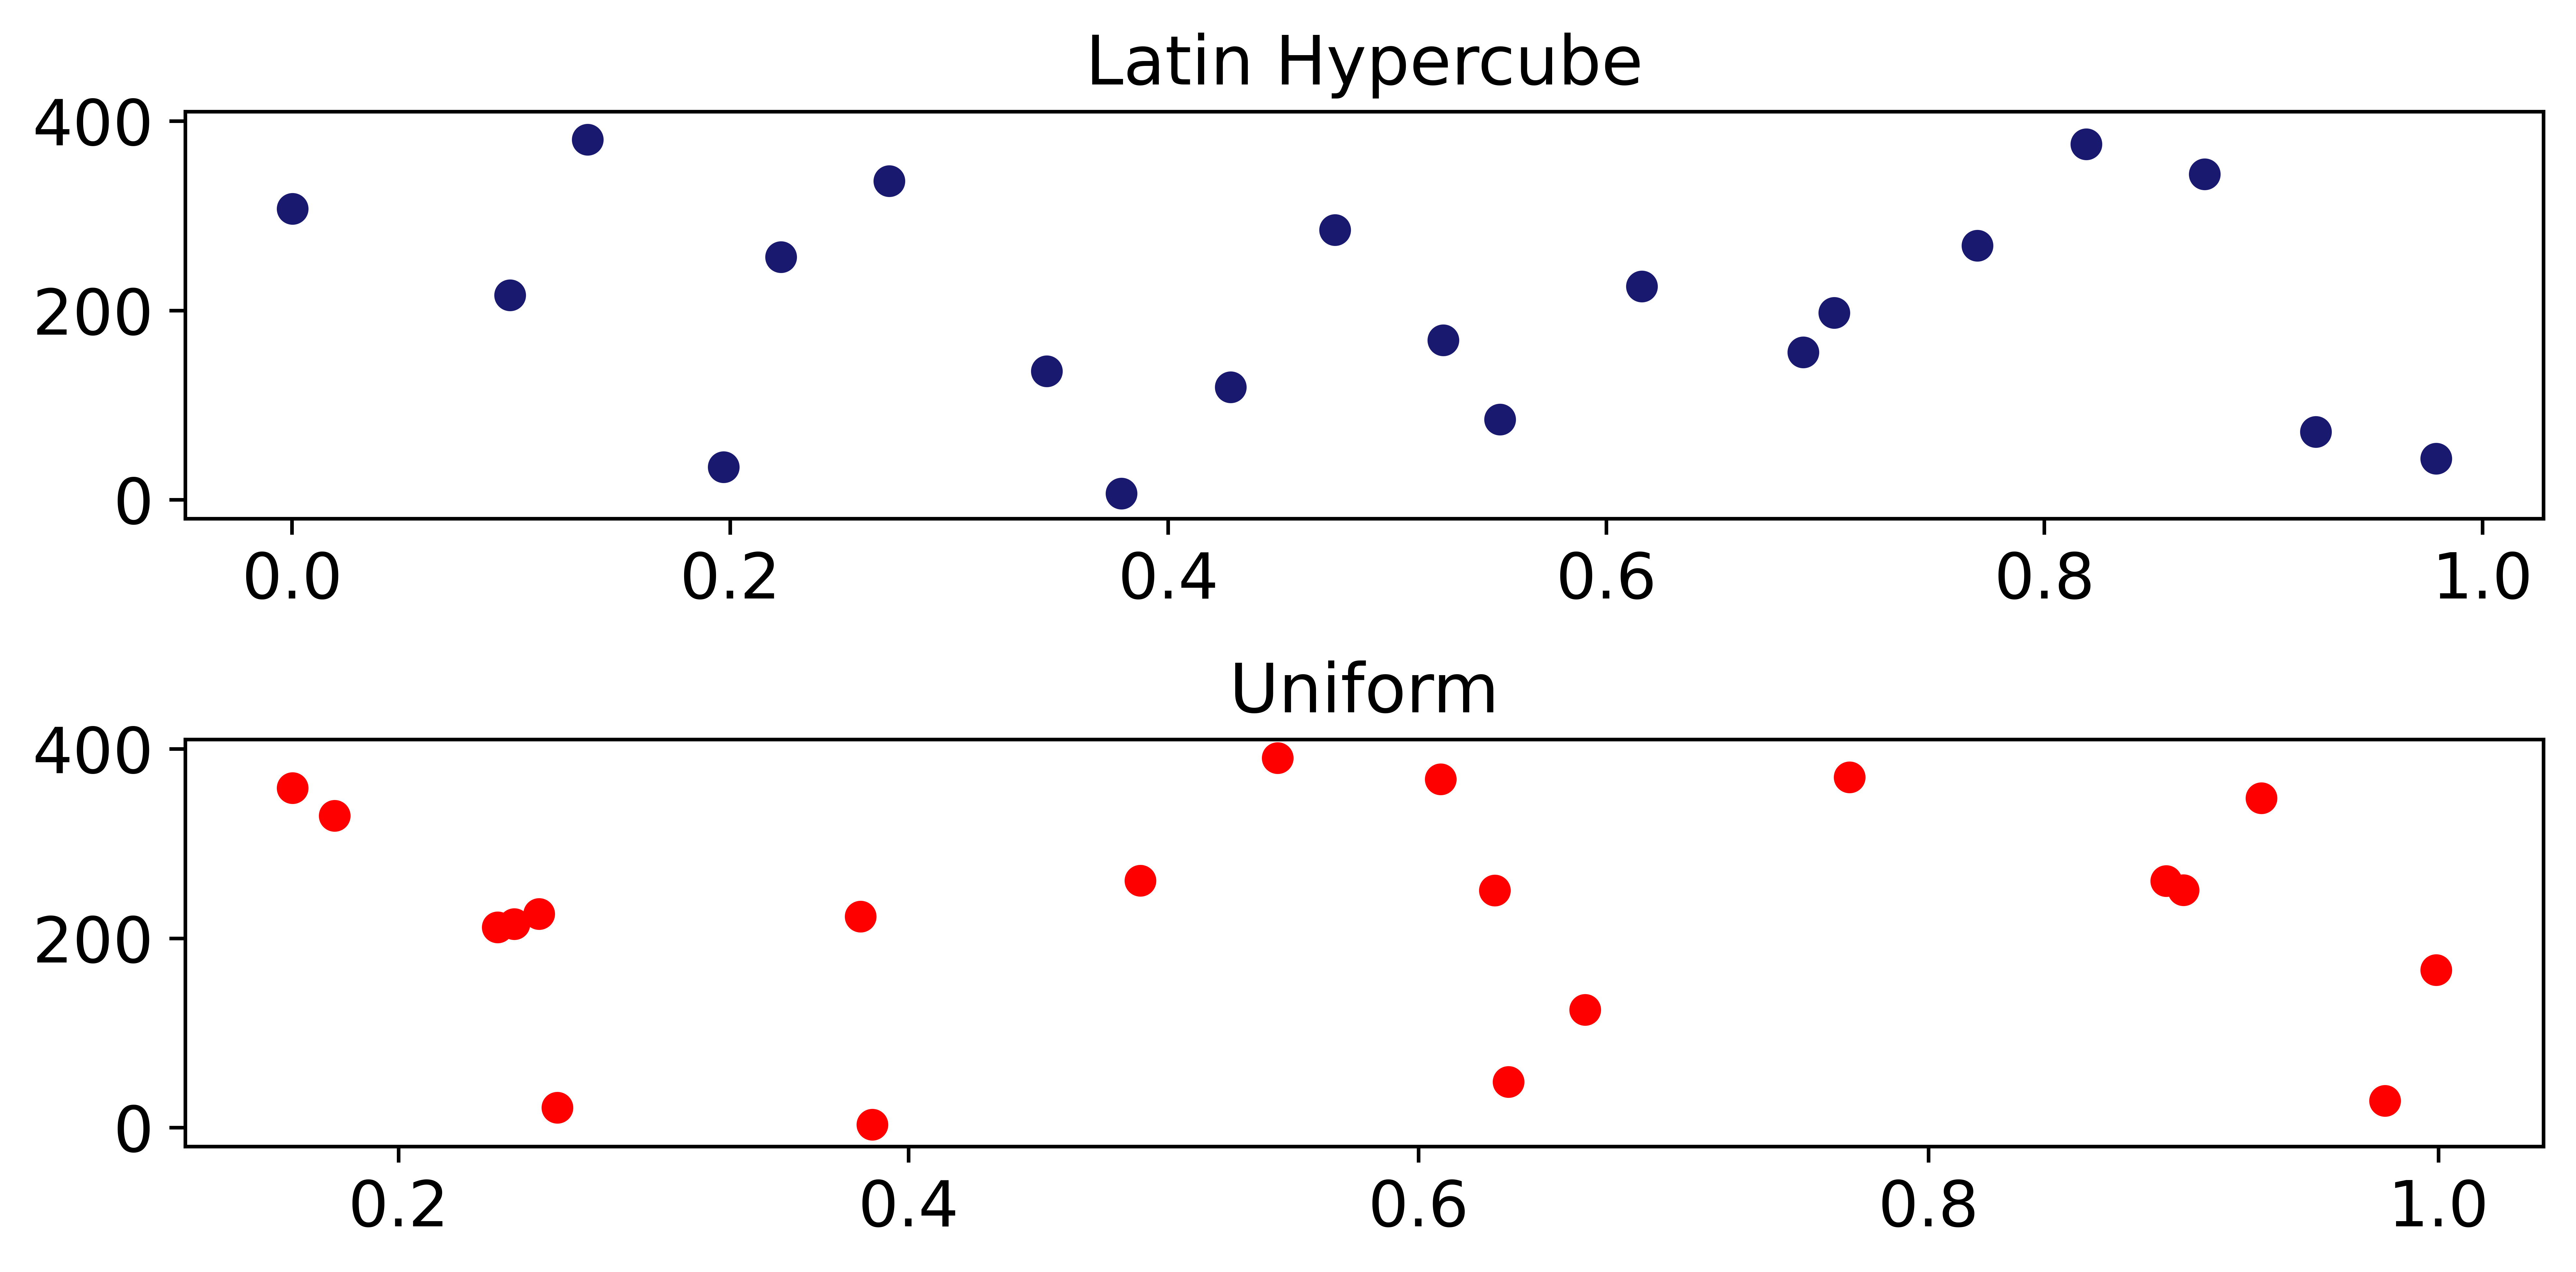

In [6]:
n = 20
seed = 204
np.random.seed(seed)
sampler_2D = qmc.LatinHypercube(d=2, seed=seed)
sample = sampler_2D.random(n=n)
time_range = [0,1]
S_range = [0,400]

X_latin = qmc.scale(sample, [time_range[0], S_range[0]], [time_range[1], S_range[1]])

X_uniform = np.concatenate([np.random.uniform(*time_range, (n, 1)),
                    np.random.uniform(*S_range, (n, 1))], axis=1)

x1, y1 = X_latin[:,0], X_latin[:,1]
x2, y2 = X_uniform[:,0], X_uniform[:,1]

fig, ax = plt.subplots(2, 1, figsize=(8, 4))

ax[0].scatter(x1, y1, color="midnightblue", label = "Latin Hypercube")
#ax[0].grid()
ax[0].set_title("Latin Hypercube")
ax[0].set_ylim((-20,410))

ax[1].scatter(x2, y2, color = "red")
ax[1].set_title("Uniform")
ax[1].set_ylim((-20,410))

fig.tight_layout()
plt.savefig("plots/sampling.pdf")

# Plotting a put and call option

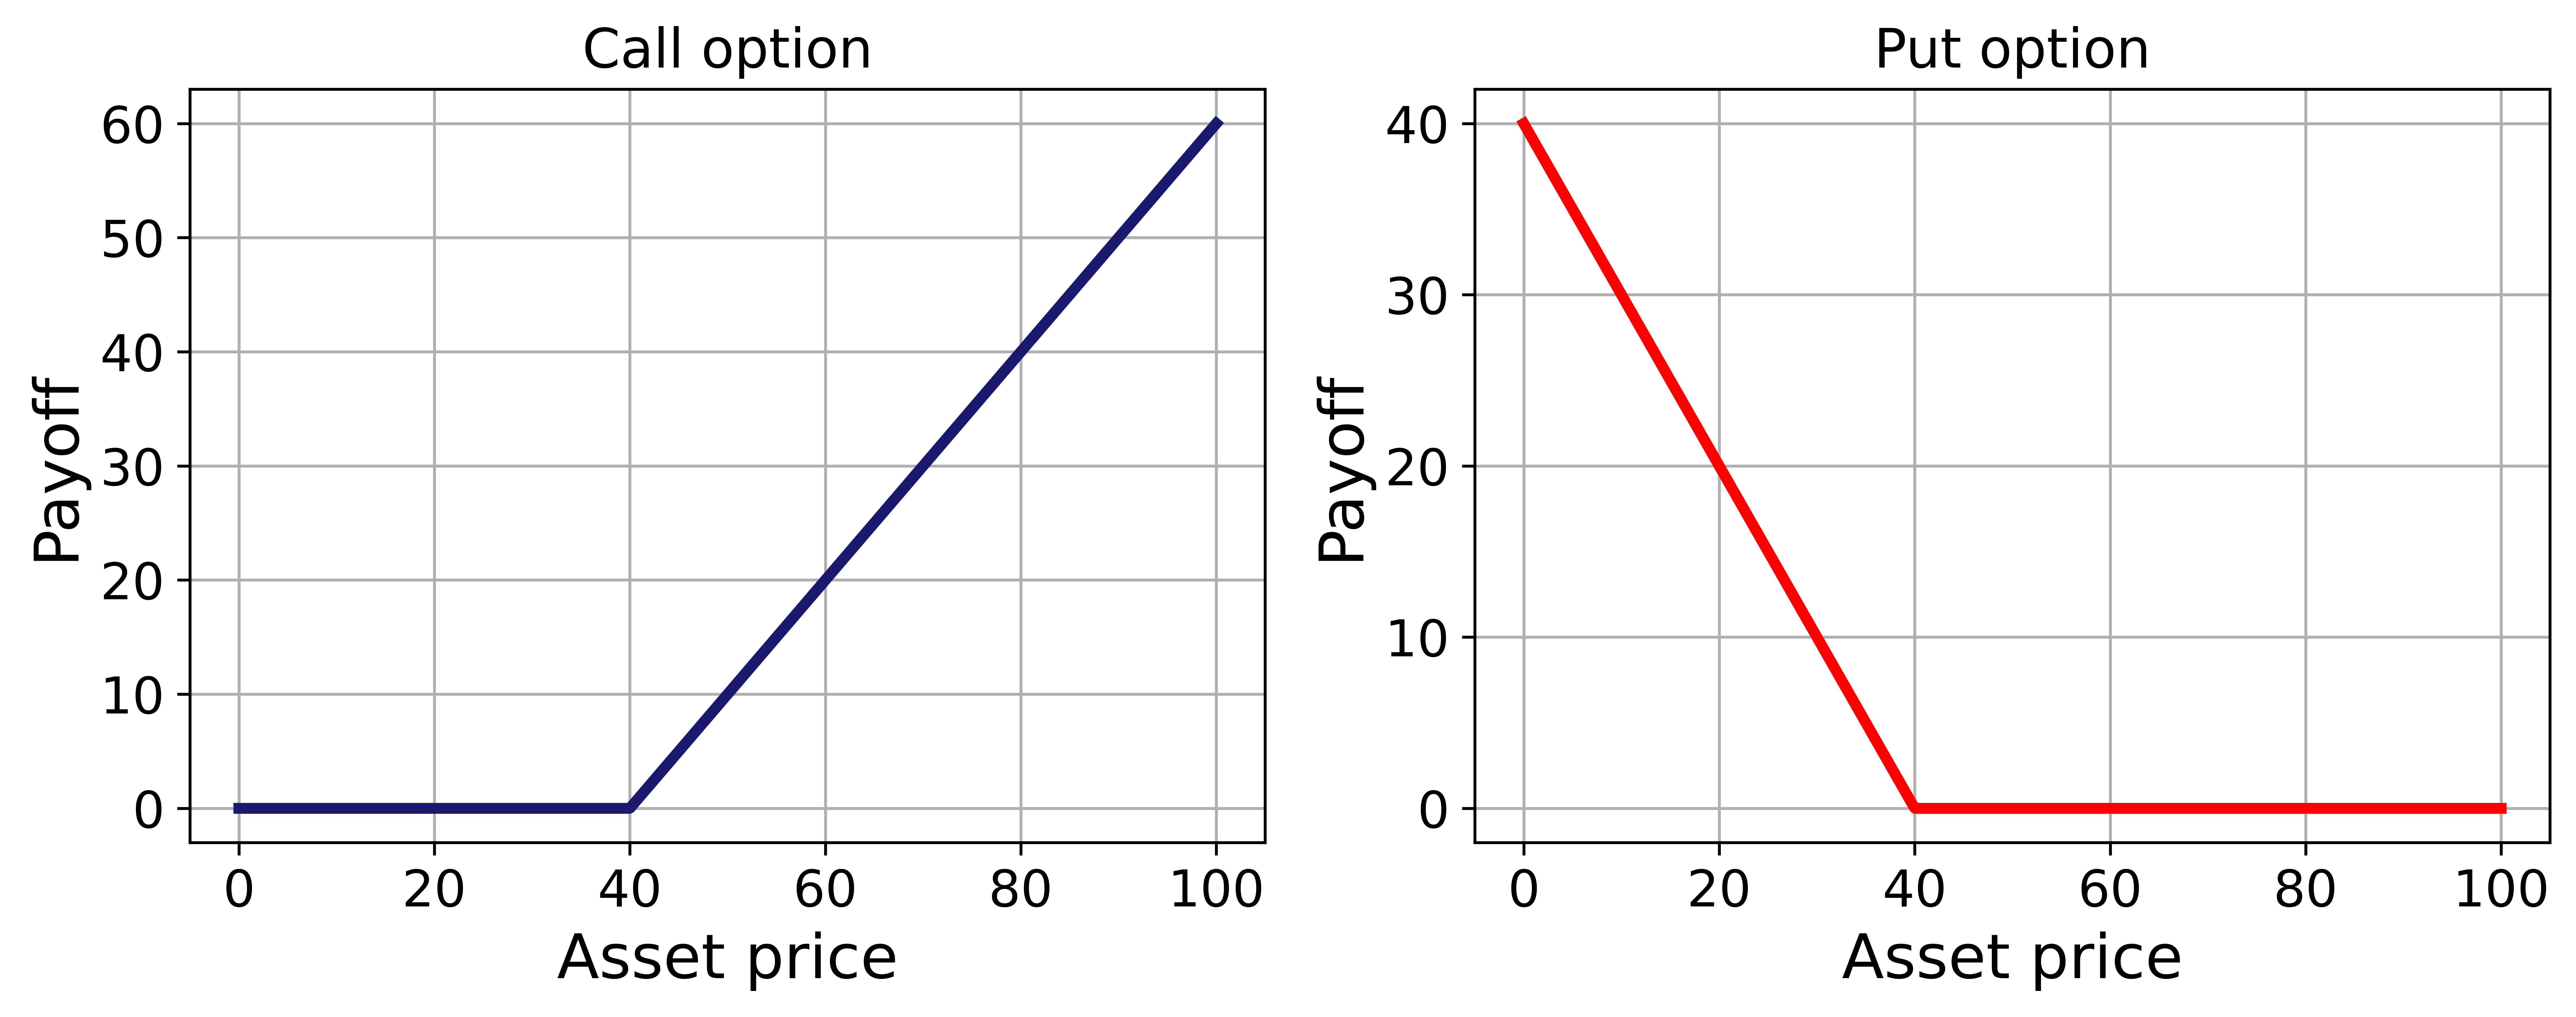

In [7]:
# Parameters
strike_price = 40  # Example strike price
stock_prices = np.linspace(0, 100, 1_000)  # Range of stock prices

# Calculate payoffs
call_payoff = np.maximum(stock_prices - strike_price, 0)
put_payoff = np.maximum(strike_price - stock_prices, 0)

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(stock_prices, call_payoff, label = "Payoff", color = "midnightblue", linewidth=3)
#ax[0].legend()
ax[0].grid()
ax[0].set_title("Call option")
ax[0].set_xlabel("Asset price")
ax[0].set_ylabel("Payoff")

ax[1].plot(stock_prices, put_payoff, label = "Payoff", color = "red", linewidth=3)
ax[1].grid()
ax[1].set_title("Put option")
ax[1].set_xlabel("Asset price")
ax[1].set_ylabel("Payoff")

fig.tight_layout()
plt.savefig("plots/call_versus_put.pdf")

# 3D plot of European call option

In [8]:
from scipy.stats import norm
T = 1
K = 40
r = 0.04
sigma = 0.5

n = 100

s = np.linspace(1e-8, 400, n)
t = np.linspace(0, 1-1e-7, n)

tmp_S, tmp_t = np.meshgrid(s,t)

t2m = T-tmp_t  # Time to maturity
#t2m = t2m.flatten()

d1 = (np.log(tmp_S / K) + (r + 0.5 * sigma**2)
      * t2m) / (sigma * np.sqrt(t2m))

d2 = d1 - sigma * np.sqrt(t2m)

# Normal cumulative distribution function (CDF)
normal = norm(loc=0, scale=1)

Nd1 = normal.cdf(d1)
Nd2 = normal.cdf(d2)

# Calculate the option price
F = tmp_S * Nd1 - K * Nd2 * np.exp(-r * t2m)

In [17]:

fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])


ax = fig.add_subplot(gs[0], projection='3d')
surf = ax.plot_surface(tmp_S, tmp_t, F,cmap='viridis',
                       linewidth=0, antialiased=False)

ax.view_init(azim=-100)

# Add axis labels
ax.set_xlabel('Asset price')
ax.set_zlabel('Option price', labelpad = 10)
ax.tick_params(axis='z', which='major', pad=5)

ax.yaxis.set_rotate_label(False)  # disable automatic rotation
ax.set_ylabel('Time', rotation=180 + 100, labelpad = 10)
ax.tick_params(axis='y', which='major', pad=5)
#fig.colorbar(surf, shrink=0.5, aspect=10)
#

ax2 = fig.add_subplot(gs[1])
#heatmap = ax2.imshow(F, cmap='viridis', aspect='auto', origin='lower',
#                     extent=[tmp_S.min(), tmp_S.max(), tmp_t.min(), tmp_t.max()])

end = 16

ax2.plot(s[:end], F[0, :end], label = f"t = {t[0]:.2f}")
ax2.plot(s[:end], F[30, :end], label = f"t = {t[30]:.2f}")
ax2.plot(s[:end], F[60, :end], label = f"t = {t[60]:.2f}")
ax2.plot(s[:end], F[90, :end], label = f"t = {t[90]:.2f}")

ax2.set_xlabel('Asset price')
ax2.set_ylabel('Option price')
ax2.set_xlim([0,61])
ax2.legend()
#cbar2 = fig.colorbar(heatmap, ax=ax2, orientation='vertical')
#cbar2.set_label('Option price')

fig.tight_layout()

#plt.show()
plt.savefig("plots/european_call.png")

# Extracting Apple call option data

In [18]:
cols = ["[QUOTE_DATE]", "[UNDERLYING_LAST]", "[EXPIRE_DATE]", "[C_ASK]", "[STRIKE]", "[C_IV]", "[DTE]"]
master = pd.DataFrame(columns = cols)
years = ["aapl_eod_2016-kak6vo", "aapl_eod_2017-b6lbj3", "aapl_eod_2018-cv9cwv", "aapl_eod_2019-ubqxfb",
        "aapl_eod_2020-e0djad"]

for j, y in enumerate(years, 2016):
    print(j)
    for i in range(1, 12 + 1):
        df = pd.read_csv(f"raw_apple_data/{y}/aapl_eod_{j}{i:02d}.txt", sep=", ", engine = "python")
        #cols = df.columns
        df = df[cols]
        master = pd.concat([master, df], axis = 0, ignore_index=True)

        
# Apple performed a stock split on August 28, 2020
master = master[master["[QUOTE_DATE]"] <= "2019-12-31"]
master

2016
2017
2018
2019
2020


[QUOTE_DATE]  [UNDERLYING_LAST] [EXPIRE_DATE]  [C_ASK]  [STRIKE]  \
0        2016-01-04             105.35    2016-01-08    45.51      60.0   
1        2016-01-04             105.35    2016-01-08    40.51      65.0   
2        2016-01-04             105.35    2016-01-08    35.49      70.0   
3        2016-01-04             105.35    2016-01-08    30.51      75.0   
4        2016-01-04             105.35    2016-01-08    25.51      80.0   
...             ...                ...           ...      ...       ...   
722599   2019-12-31             293.20    2022-01-21     6.00     460.0   
722600   2019-12-31             293.20    2022-01-21     5.51     470.0   
722601   2019-12-31             293.20    2022-01-21     4.99     480.0   
722602   2019-12-31             293.20    2022-01-21     4.50     490.0   
722603   2019-12-31             293.20    2022-01-21     3.50     500.0   

         [C_IV]  [DTE]  
0       0.00030    4.0  
1      -0.00042    4.0  
2      -0.00010    4.0  
3      -0.00035    4.0  
4       0.00013    4.0  
...         ...    ...  
722599  0.23326  752.0  
722600  0.23179  752.0  
722601  0.23212  752.0  
722602  0.23210  752.0  
722603  0.24195  752.0  

[722604 rows x 7 columns]

In [11]:
import collections
#print(np.max(master["[STRIKE]"].values))
counter = collections.Counter(master["[STRIKE]"].values)
counter.most_common()

[(150.0, 13829),
 (160.0, 13537),
 (155.0, 13529),
 (165.0, 13382),
 (170.0, 13205),
 (145.0, 13185),
 (175.0, 13120),
 (130.0, 13113),
 (180.0, 13081),
 (140.0, 13041),
 (135.0, 13029),
 (125.0, 12965),
 (120.0, 12812),
 (115.0, 12732),
 (110.0, 12597),
 (185.0, 12572),
 (190.0, 12479),
 (105.0, 12381),
 (195.0, 12312),
 (100.0, 11918),
 (200.0, 11661),
 (95.0, 11124),
 (210.0, 10914),
 (90.0, 10458),
 (205.0, 10358),
 (220.0, 9828),
 (85.0, 9713),
 (215.0, 9389),
 (230.0, 9355),
 (80.0, 9078),
 (225.0, 8989),
 (240.0, 8617),
 (235.0, 8272),
 (75.0, 8256),
 (250.0, 8254),
 (245.0, 7581),
 (260.0, 6999),
 (70.0, 6930),
 (65.0, 6271),
 (60.0, 6149),
 (270.0, 5943),
 (55.0, 5939),
 (280.0, 5575),
 (290.0, 5377),
 (50.0, 5298),
 (300.0, 5283),
 (255.0, 5130),
 (265.0, 4642),
 (97.5, 4579),
 (275.0, 3982),
 (285.0, 3729),
 (187.5, 3591),
 (182.5, 3527),
 (295.0, 3493),
 (310.0, 3486),
 (92.5, 3463),
 (172.5, 3454),
 (320.0, 3380),
 (177.5, 3347),
 (167.5, 3343),
 (192.5, 3337),
 (162.5, 32

In [12]:
# Extract call option's with strike price 150.0
df = master.loc[master["[STRIKE]"] == 150.0].reset_index(drop=True)

# Time is given in years
df["t"] = df["[DTE]"].values / 365

df = df.rename(columns={'[C_ASK]':"Price", "[UNDERLYING_LAST]" : "S"})

In [16]:
df_final = df[["t", "S", "Price"]].dropna().reset_index(drop=True)
df_final.to_csv("data/apple_data.csv", index=False)

# Computing risk-free rate

In [14]:
df_rate = pd.read_csv("apple_data/DGS10.csv").dropna()
df_rate = df_rate[df_rate["observation_date"] <= "2019-12-31"]
df_rate

observation_date  DGS10
0          2016-01-04   2.24
1          2016-01-05   2.25
2          2016-01-06   2.18
3          2016-01-07   2.16
4          2016-01-08   2.13
...               ...    ...
1036       2019-12-24   1.90
1038       2019-12-26   1.90
1039       2019-12-27   1.88
1040       2019-12-30   1.90
1041       2019-12-31   1.92

[999 rows x 2 columns]

In [15]:
print(f"Average risk-free rate: {np.mean(df_rate['DGS10'].values)/100:.4f}")

Average risk-free rate: 0.0230
